In [33]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ["LANGCHAIN_API_KEY"] = os.getenv('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = os.getenv('LANGCHAIN_TRACING_V2')
os.environ["LANGCHAIN_ENDPOINT"] = os.getenv('LANGCHAIN_ENDPOINT')
os.environ["TAVILY_API_KEY"] = os.getenv('TAVILY_API_KEY')
os.environ["HF_HOME"] = os.getenv("HF_HOME")

MODEL_NAME = "llama-3.1-8b-instant"

In [34]:
from langchain_community.document_loaders import WebBaseLoader 
from langchain_community.vectorstores import FAISS 
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
doc_list = [doc for sublist in docs for doc in sublist]
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
doc_splits = text_splitter.split_documents(doc_list)

In [35]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(documents=doc_splits, embedding=embeddings)

retriever = vectorstore.as_retriever()

In [36]:
from pydantic import BaseModel, Field 
from typing import Literal
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser

class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(..., description="Given a user question, choose to route it to web search or vector store")

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

llm = ChatGroq(model=MODEL_NAME)
structured_llm_router = llm.with_structured_output(RouteQuery)

In [37]:
from langchain_core.prompts import ChatPromptTemplate

# Prompt
system = """You are an expert at routing user question to a vectorstore or web search. The vectorstore contains documents related to agents, prompt engineering and adverserial attacks. Use the vectorstore for questions related to these topics, otherwise use web search."""

route_prompt = ChatPromptTemplate.from_messages(
    [
        "system", system,
        "human", "{question}"
    ]
)

question_router = route_prompt | structured_llm_router

# print(question_router.invoke({"question": "What are the types of agent memory?"}))

In [38]:
# Retrieval grader 
class GradeDocuments(BaseModel):
    """Binary score for relevance check of retrieved documents"""

    binary_score: str = Field(description="Documents are relevant to the question 'yes' or 'no'")

llm = ChatGroq(model=MODEL_NAME)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [39]:
# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        "system", system,
        "human", "Retrieved document:\n{document}\n\n User question: {question}"
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content 

# print(retrieval_grader.invoke({"question": question, "document": doc_txt}))


In [40]:
# Generate 
from langchain import hub 
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

prompt = hub.pull('rlm/rag-prompt')
llm = ChatGroq(model=MODEL_NAME)
rag_chain = prompt | llm | StrOutputParser()

generation = rag_chain.invoke({"question": question, "context": docs})
print(generation)


In an LLM-powered autonomous agent system, memory consists of two types: short-term memory and long-term memory. Short-term memory utilizes in-context learning, while long-term memory provides the ability to retain and recall information over extended periods through an external vector store and fast retrieval.


In [41]:
# Hallucination grader 

class GradeHallucinations(BaseModel):
    """Binary score for hallucinations present in the generated answer"""

    binary_score: str = Field(description="Answer is grounded in the facts, 'yes' or 'no'")

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

llm = ChatGroq(model=MODEL_NAME)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        "system", system,
        "human", "Set of facts:\n{documents}\n\n LLM generation: {generation}"
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader

print(hallucination_grader.invoke({"generation": generation, "documents": docs}))


binary_score='no'


In [42]:
# Answer question - Yes/No 

class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(descrition="Answer addresses the question, 'yes' or 'no'")

# Prompt
system = """You are a grader assessing whether an answer addresses/resolves a question. \n Give a binary score 'yes' or 'no. Yes means that the answer resolves the question."""

llm = ChatGroq(model=MODEL_NAME)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

answer_prompt = ChatPromptTemplate.from_messages(
    [
        "system", system,
        "human", "User question:\n{question}\n\n LLM generation: {generation}"
    ]
)

answer_grader = answer_prompt | structured_llm_grader

print(answer_grader.invoke({"question": question, "generation": generation}))



C:\Users\indra\AppData\Local\Temp\ipykernel_13092\3504917433.py:6: PydanticDeprecatedSince20: Using extra keyword arguments on `Field` is deprecated and will be removed. Use `json_schema_extra` instead. (Extra keys: 'descrition'). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  binary_score: str = Field(descrition="Answer addresses the question, 'yes' or 'no'")


binary_score='yes'


In [43]:
# Rewrite question 

llm = ChatGroq(model=MODEL_NAME)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'To better capture the underlying semantic intent, I can rephrase the question as follows:\n\n"what is agent memory in artificial intelligence and how does it work?"\n\nThis rephrased question is more specific and includes relevant keywords that can help with web search, such as "artificial intelligence" and "how does it work". This should improve the chances of retrieving relevant and accurate information. \n\nAlternatively, if the question is more related to cognitive psychology or neuroscience, it could be rephrased as:\n\n"what is agent memory in cognitive psychology and what are its implications for decision-making?"\n\nThis rephrased question is more specific and includes relevant keywords that can help with web search, such as "cognitive psychology" and "decision-making". This should improve the chances of retrieving relevant and accurate information. \n\nIn another alternative, the question could be rephrased to make it more specific to the field of computer science:\n\n"what i

### LangGraph implementation

In [44]:
from typing_extensions import TypedDict 
from typing import List

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str 
    generation: str 
    documents: List[str]

In [45]:
from langchain.schema import Document 

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """ 
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG Generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {
        "documents": documents, "question": question, "generation": generation
    }

def grade_document(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each document 
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke({
          "question": question, "document": d.page_content   
        })
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    
    return {
        "documents": filtered_docs,
        "question": question
    }

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    print("web results", web_results)

    return {"documents": web_results, "question": question}

# Edges 
def route_question(state):
    """
    Route question to web search or RAG.

    Args: 
        state (dict): The current graph state
    
    Returns:    
        str: Next node to call
    """
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    else: 
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

# Edges 
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    filtered_documents = state["documents"]

    if not filtered_documents:
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else: 
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

def grade_v_documents_and_question(state):
    """
    Determines whether to generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")

    question = state["question"]
    documents = state["documents"]
    score = hallucination_grader.invoke({
        "documents": documents, 
        "generation": generation
    })
    grade = score.binary_score
    if grade == "yes":
        print("---DECISION GENERATION IS GROUNDED IN THE DOCUMENTS---")

        # Check question-answering 
        print("---CHECK GRADE GENERATION v/s QUESTION---")
        score = answer_grader.invoke({
            "question": question,
            "generation": generation
        })
        grade = score.binary_score

        if grade == "yes":
            print("---DECISION GENERATION ANSWERS QUESTION---")
            return "useful"
        else:
            print("---DECISION GENERATION DOES NOT ANSWER QUESTION---")
            return "not useful"

    else: 
        print("---DECISION GENERATION IS NOT GROUNDED IN THE DOCUMENTS---")
        return "not supported"

In [46]:
from langgraph.graph import START, END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes 
workflow.add_node("web_search", web_search) 
workflow.add_node("retrieve", retrieve)  
workflow.add_node("grade_documents", grade_document)  
workflow.add_node("generate", generate)  
workflow.add_node("transform_query", transform_query)  

# Build graph 
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve"
    }
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents", 
    decide_to_generate, 
    {
        "transform_query": "transform_query",
        "generate": "generate"
    }
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate", 
    grade_v_documents_and_question, 
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query"
    }
)

app = workflow.compile()


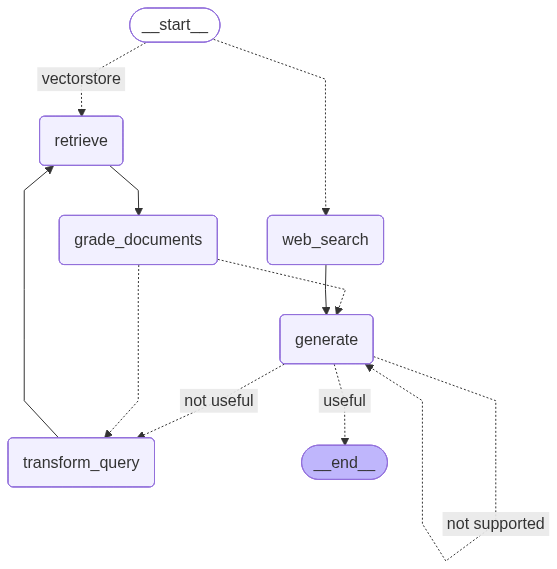

In [47]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
app.invoke({"question":"What is deep learning?"})

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION GENERATION IS GROUNDED IN THE DOCUMENTS---
---CHECK GRADE GENERATION v/s QUESTION---
---DECISION GENERATION ANSWERS QUESTION---


{'question': 'What is agent memory?',
 'generation': "Agent memory refers to the long-term memory module in a LLM-powered autonomous agent system that records a comprehensive list of the agent's experience in natural language. This memory is stored externally in a database and allows the agent to retain and recall information over extended periods. It is used to inform the agent's behavior through a retrieval model that surfaces context according to relevance, recency, and importance.",
 'documents': [Document(id='74d05986-d83e-44eb-bb10-7930e4b093d6', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; i